In [1]:
import argparse
import os, sys
import time
import copy
import math
import pickle
import statistics

import numpy as np
import pandas as pd
import open3d as o3d
import torchvision
import pytorch3d
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Import pytorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.modules.utils import _single, _pair, _triple
from torchsummary import summary

from pytorch3d.loss import chamfer_distance

# Import toolkits
from utils.visualization_3D_objects import *
from utils.preprocessing import *
from utils.read_object import *
from utils.model_averaging import *
from utils.model_PCA import *
from utils.morphable_model import *

from model.model import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
DATA_PATH = "./data/processedShapeNet/car/"
TRAIN_BATCH_SIZE = 12
VAL_BATCH_SIZE = 10
INITIAL_LR = 1e-3
MOMENTUM = 0.9
EPOCHS = 200
DECAY_EPOCHS = 30
DECAY = 0.7
CHECKPOINT_FOLDER = "./saved_model"
MODEL_TYPE = "PointNetAE"

### Import Preprocessed ModelNet40 cars (Run shapenet_preprocessing.ipynb first to get these data)

In [3]:
#load all aligned cars
f1 = open(DATA_PATH+'train.txt','rb')
X_train = pickle.load(f1)
f2 = open(DATA_PATH+'test.txt','rb')
X_test = pickle.load(f2)

In [4]:
# construct dataloader
train_loader = DataLoader(
    X_train, 
    batch_size=TRAIN_BATCH_SIZE, 
    shuffle=True, 
    num_workers=4,
    drop_last=True
)
val_loader = DataLoader(
    X_test, 
    batch_size=VAL_BATCH_SIZE, 
    shuffle=False, 
    num_workers=4,
    drop_last=True
)
full_loader = DataLoader(
    np.vstack([X_train, X_test]), 
    batch_size=VAL_BATCH_SIZE, 
    shuffle=False, 
    num_workers=4,
    drop_last=True
)

### Load saved model

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")
    
model_test = PointNet_AE(3, 2048)
state_dict = torch.load(os.path.join(CHECKPOINT_FOLDER, MODEL_TYPE + '.pth')) # change the path to your own checkpoint file
model_test.cuda()
model_test.load_state_dict(state_dict['state_dict'])
model_test.eval()

print("Best Epoch: ", state_dict['epoch'])

Run on GPU...
Best Epoch:  192


In [6]:
def extractGlobalFeatForAllData(full_loader, model_test, device):
    global_feat_lst = []
    for batch_idx, (inputs) in enumerate(full_loader):
        # copy inputs to device
        inputs = inputs.float().to(device)
        # compute the output and loss
        outputs, global_feat_i = model_test(inputs)
        global_feat_lst.append(global_feat_i.cpu().detach().numpy())
        
    global_feat = np.vstack(global_feat_lst)
    return global_feat

global_feat = extractGlobalFeatForAllData(full_loader, model_test, device)
print(global_feat.shape)

(1820, 1024)


(-51.150000000000006, 1074.15, -12.791693960875273, 270.655221452564)

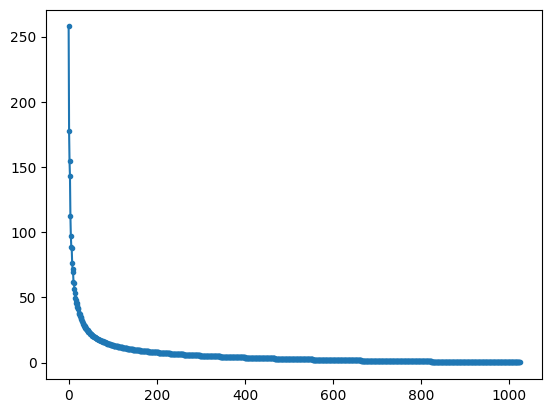

In [7]:
mu, var = np.mean(global_feat, axis = 0), np.var(global_feat, axis = 0)
U, D, V = np.linalg.svd(global_feat - mu)
plt.clf
plt.plot(D, '.-')
plt.axis('tight')

In [21]:
weights = (global_feat - mu) @ V
print(weights.shape, V.shape)

fitted_model = mu + weights @ (V.T)
print(fitted_model.shape)

print(((global_feat[0] - fitted_model[0])**2).mean())

mu_w, var_w = np.mean(weights, axis = 0), np.var(weights, axis = 0)
print(mu_w, var_w)
print(mu_w.shape, var_w.shape)

lower_bound = mu_w - var_w * 10
higher_bound = mu_w + var_w * 10
print(lower_bound, higher_bound)

(1820, 1024) (1024, 1024)
(1820, 1024)
2.3314684e-14
[-1.3818617e-06  2.5284978e-06  4.8276485e-07 ...  2.1274109e-06
 -6.9462338e-08  2.0117141e-06] [0.1385694  0.11420961 0.10472102 ... 0.15009108 0.24390942 0.07810207]
(1024,) (1024,)


(20, 1820, 3, 2048)


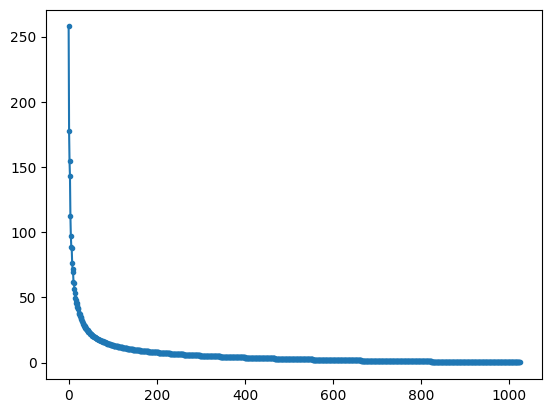

In [28]:
def computeAllDataPCA(global_feat, model_test, top_k = 10, mod_range = 50, n_step = 20):
    '''
    (Documentation)
    '''
    # get statistical distribution of global feature
    mu, var = np.mean(global_feat, axis = 0), np.var(global_feat, axis = 0)

    # SVD on global feature to extract linearly independent basis of feature
    U, D, V = np.linalg.svd(global_feat - mu)
    plt.clf
    plt.plot(D, '.-')
    plt.axis('tight')

    # get statistical distribution of weights
    weights = (global_feat - mu) @ V
    mu_w, var_w = np.mean(weights, axis = 0), np.var(weights, axis = 0)

    # define dictionary to save all generated data
    X_list = dict()
    for idx in range(top_k):
        X_feat_list = []
        
        lower_bound = mu_w[idx] - var_w[idx] * mod_range
        higher_bound = mu_w[idx] + var_w[idx] * mod_range
        for step in np.linspace(lower_bound, higher_bound, n_step):
            # perturb weight at idx dimension 
            new_weights = np.copy(weights)
            new_weights[:, idx] = step

            # generate new features from perturbed weights
            new_features = mu + new_weights @ (V.T)
            new_features = torch.from_numpy(new_features).cuda()

            # decode new features
            X = model_test.decoder(new_features).cpu().detach().numpy()
            X_feat_list.append(X)

        X_feat_list = np.asarray(X_feat_list)
        X_list[idx] = X_feat_list

    return X_list

X_list = computeAllDataPCA(global_feat, model_test)
print(X_list[0].shape)

In [29]:
def examineObj(obj_idx):
    for idx in X_list.keys():
        draw3DpointsSlider(X_list[idx], idx, obj_idx)
        end = int(input("Are you finished? 0: No, 1: Yes"))
        if (end == 1):
            break
        
        clear_output(wait=True)

examineObj(0)

In [ ]:
draw3DpointsSlider(X_list[0], 0, 1)